In [1]:
%load_ext autoreload
%autoreload 2
import sys

sys.path.append('../../')
from config import *

configure_pylab()

Available files:
	r2288_180515b_tet2_cell2_GC.mat
	r2289_250515b_tet2_cell2_GC.mat
	r2298_290615c_tet6_cell6_GC.mat
	r2375_070416a_tet1_cell1_GC.mat
	r2375_140416b_tet1_cell1_GC.mat
	r2375_210416a_tet3_cell3_GC.mat
	r2383_160516b_tet4_cell4_GC.mat
	r2405_011216a_cell2955.mat
	r2405_051216b_cell1816.mat
	r2405_121216b_cell1880.mat
	r2405_121216b_cell1912.mat
	r2405_191216c_cell1640.mat
	r2405_191216c_cell1662.mat
	r2405_191216c_cell1962.mat
	r2405_191216c_cell1990.mat
Fitted models in fitdir = /home/mer49/Dropbox (Cambridge University)/Notebooks/PCV/LGCP/lgcpspatial v13/python/notebooks/hyperparameter_fits/


# Simulation 

σ² = 0.020000 bin²/second
τ = 189 ms


/home/mer49/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,


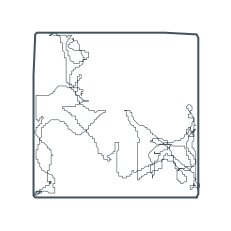

In [2]:
rate     = 1.2  # Spikes/second
Fs       = 50   # Samples/second
duration = 1800 # Seconds
T        = int(duration*Fs) # Samples
L        = 128  # Bins/arena
Po       = 13   # Bins/field

# Generate intensity map: Exponentiate and scale mean rate
r0 = np.exp(ideal_hex_grid(L,Po)*0.5)

# Zero pad edges
pad  = L*15//100
mask = np.zeros((L,L),dtype='bool')
mask[pad:-pad,pad:-pad]=1
r0 = r0*mask

# Add background rate changes
coords = zgrid(L)
r0_bg = r0*(1-np.abs(coords/(L-2*pad)))

# Correct to reach target firing rate
correct = rate/mean(r0_bg[mask>0])
r0    *= correct
r0_bg *= correct

# Simulate arena exploration
x  = float32([.5,.5])
xt = float32([.5,.5])
x2 = float32([.5,.5])
X  = zeros((T,2))
for t in range(T):
    xt = clip(xt+randn(2)*0.02,0,1)
    x2 = 0.9*x2 + 0.1*xt
    x  = 0.9*x  + 0.1*x2
    X[t,:] = x

# Sample grid cell spikes during exploration
YX   = int32(X*(L-2*pad)+pad)
rt   = r0_bg[tuple(YX.T)]
s    = np.random.poisson(rt/Fs)
y,x  = YX.T/L

# Run inference
data   = Dataset(x,y,s).prepare(L,margin=.15)
arena  = data.arena

arena.imshow(NaN*r0,color=BLACK,lw=2)
plot(x[1500:4500],y[1500:4500],lw=.6)

print('σ² = %f bin²/second'%( (0.02*sqrt(50))**2 ))
print('τ = %d ms'%(-1/log(.9**50)*1000))

In [3]:
kernel = kernelft(data.shape,data.P,data.V)
result,model  = lgcp2d(kernel,data.N,data.K,data.prior_mean) # zv,nll,(r,μ,vm)
params,result = optimize_PVtheta(data.N,data.K,data.prior_mean,data.P,data.V)
P,V,θ = params
print('(P,V,θ) =',(P,V,θ))
(z,v), nll, (r,zh,vh,mu) = result
kernel = kernelft(data.shape,P,V,style='grid',angle=θ)
result,model = lgcp2d(kernel,data.N,data.K,data.prior_mean)

[24,16](1.40e+01,2.50e-01) loss=-9.709238e+03(done)
Optimized parameters:                                                 
P = 13.574494
V = 0.249957
θ = 58.000000°
(P,V,θ) = (13.574494, 0.24995707, 1.0122909661567112)


# Accuracy

In [4]:
saved = []
nnuse = int32(float32([1,2,5,10,15,20,30])*Fs*60)
nnuse = int32(float32([4,6,8,12,16,24,30])*Fs*60)
for NUSE in nnuse: 
    N,K = data.arena.binto((x[:NUSE],y[:NUSE]),s[:NUSE])
    result,model = lgcp2d(kernel,N,K,data.prior_mean,tol=1e-5,verbose=False)
    a  = r0_bg[where(mask)]/Fs
    ii = int32(data.arena.meters_to_bins(float32(where(mask))/L))
    b  = result.info.r[tuple(ii)]
    c  = kde(N,K,P/pi/sqrt(2))[tuple(ii)]
    d  = kde(N,K,P/pi/sqrt(4))[tuple(ii)]
    e  = kde(N,K,P/pi/sqrt(8))[tuple(ii)]
    f  = kde(N,K,P/pi/sqrt(16))[tuple(ii)]
    saved.append([
        scipy.stats.pearsonr(a,b).statistic,
        scipy.stats.pearsonr(a,c).statistic,
        scipy.stats.pearsonr(a,d).statistic,
        scipy.stats.pearsonr(a,e).statistic,
        scipy.stats.pearsonr(a,f).statistic,
    ])
saved = float32(saved).T

In [5]:
# Divide data into crossvalidation blocks
nsampl  = len(data.spikes)
nblocks = 15
bedges  = int32(linspace(0,nsampl,nblocks+1))
bstart  = bedges[:-1]
bstop   = bedges[1:]+1
bedges  = array([bstart,bstop]).T
(x,y),s = data.xy, data.spikes
xys     = array([x,y,s]).T
μ0      = data.prior_mean

groundtruthrate = r0_bg[where(mask)]/Fs
binindeces = tuple(int32(data.arena.meters_to_bins(float32(where(mask))/L)))

def sample_estimator(nb,estimator):
    blocks = choice(arange(nblocks),nb,replace=True)
    train  = concatenate([xys[a:b,:] for (a,b) in bedges[blocks]]).T
    N,K    = data.arena.binto(train[:2],train[2])
    return estimator(N,K)[binindeces]

NSAMPLES    = 200
NBS         = int32([2,3,4,5,6,8,10,12,15])
NBS_minutes = NBS/nblocks*nsampl/Fs/60
SIGMAS      = Po/pi/sqrt(float32([2,4,8,16]))

estimators = [lambda N,K:lgcp2d(kernel,N,K,μ0)[0].info.r]+\
   [(lambda s:lambda N,K:kde(N,K,s))(s) for s in SIGMAS]
jobs = [(nb,estimator) for nb in NBS for i in range(NSAMPLES) for estimator in estimators]
results = float32(parmap(sample_estimator,jobs))
samples = results.reshape(len(NBS),NSAMPLES,len(estimators),shape(results)[-1])

# Plot

Since dense scatter plots break Inkscape, we render them as histogram images in a separate subplot and merge later. 

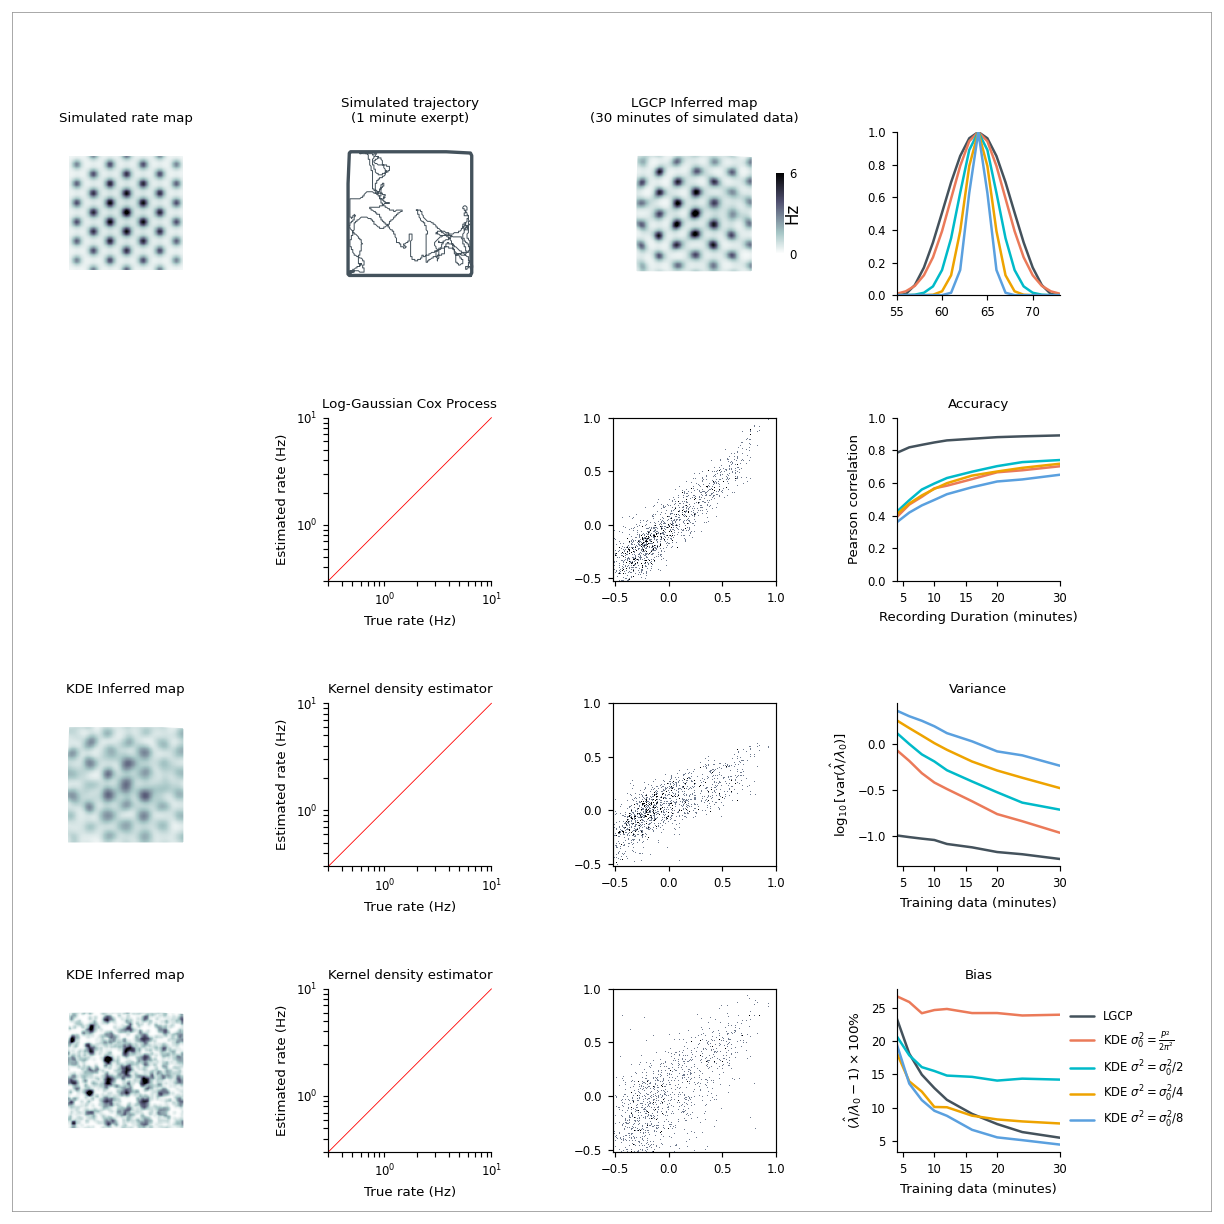

In [6]:
from scipy.stats import pearsonr


def square_limits(limit):
    xlim(*limit)
    ylim(*limit)
    plot(limit,limit,color='r',lw=0.5)
    simpleaxis()
    force_aspect()
    nicexy()
    xlim(*limit)
    ylim(*limit)
    
figure(0,(10,10),120,facecolor='w')
subplots_adjust(0,0.05,.9,.9,0.25,0.75)

subplot(441)
imshow(r0_bg*nan_mask(mask),vmin=0,vmax=6,cmap='bone_r')
title('Simulated rate map')
noxyaxes()
noclip()
subplot(442)
arena.imshow(NaN*r0,color=BLACK,lw=2)
plot(x[1500:4500],y[1500:4500],lw=.6)
title('Simulated trajectory\n(1 minute exerpt)')
noclip()
subplot(443)
im = arena.imshow(r*Fs,vmin=0,vmax=6,cmap='bone_r')
title('LGCP Inferred map\n(30 minutes of simulated data)')
vmin,vmax = im.get_clim()
good_colorbar(vmin,vmax,cmap='bone_r',title='Hz',vscale=.5,width=8,spacing=0)
noclip()

subplot(446)
ii = int32(data.arena.meters_to_bins(float32(where(mask))/L))
square_limits((.3,10))
loglog()
xlabel('True rate (Hz)'); ylabel('Estimated rate (Hz)'); title('Log-Gaussian Cox Process')
extent = tuple(xlim())+tuple(ylim())
noclip()
subplot(447)
px = (r0_bg[where(mask)])
py = (result[2].r[tuple(ii)])*Fs
ext=log10(float32(extent))
bins=linspace(log10(exp(-1)),log10(exp(2)),401)
imshow(np.histogram2d(log10(px),log10(py),bins=bins)[0].T, extent = ext, interpolation='nearest', cmap='bone_r',vmax=2)
noclip()

subplot(449)
kderate = data.kderate
kderate = kde(data.N,data.K,P/pi/sqrt(2))
arena.imshow(kderate*Fs,vmin=0,vmax=6,cmap='bone_r')
title('KDE Inferred map')
subplot(4,4,10)
ii = int32(data.arena.meters_to_bins(float32(where(mask))/L))
square_limits((.3,10))
loglog(); xlabel('True rate (Hz)'); ylabel('Estimated rate (Hz)'); title('Kernel density estimator')
noclip()
subplot(4,4,11)
px = (r0_bg[where(mask)])
py = (kderate[tuple(ii)])*Fs
imshow(np.histogram2d(log10(px),log10(py),bins=bins)[0].T, extent = ext, interpolation='nearest', cmap='bone_r',vmax=2)
noclip()

subplot(4,4,13)
kderate = data.kderate
kderate = kde(data.N,data.K,P/pi/sqrt(16))
arena.imshow(kderate*Fs,vmin=0,vmax=6,cmap='bone_r')
title('KDE Inferred map')
subplot(4,4,14)
ii = int32(data.arena.meters_to_bins(float32(where(mask))/L))
square_limits((.3,10))
loglog(); xlabel('True rate (Hz)'); ylabel('Estimated rate (Hz)'); title('Kernel density estimator')
noclip()
subplot(4,4,15)
px = (r0_bg[where(mask)])
py = (kderate[tuple(ii)])*Fs
imshow(np.histogram2d(log10(px),log10(py),bins=bins)[0].T, extent = ext, interpolation='nearest', cmap='bone_r',vmax=2)
noclip()

subplot(4,4,4)
H,W = data.shape
plot(unitscale(fftshift(fftshift(log(1e-9+r0)*mask)[0])))
plot(fftshift(blurkernel2D(Po/pi/sqrt(2),W,H)[0]))
plot(fftshift(blurkernel2D(Po/pi/sqrt(4),W,H)[0]))
plot(fftshift(blurkernel2D(Po/pi/sqrt(8),W,H)[0]))
plot(fftshift(blurkernel2D(Po/pi/sqrt(16),W,H)[0]))
simpleaxis()
xlim(L//2-9,L//2+9)
ylim(0,1)
force_aspect(1)

names = [
    'LGCP',
    'KDE $\\sigma_0^2=\\frac{P^2}{2\\pi^2}$',
    'KDE $\\sigma^2=\\sigma_0^2/2$',
    'KDE $\\sigma^2=\\sigma_0^2/4$',
    'KDE $\\sigma^2=\\sigma_0^2/8$']
subplot(4,4,8)
for i,ss in enumerate(samples.transpose(2,0,1,3)):
    rho = float32([[pearsonr(groundtruthrate,sii).statistic for sii in si] for si in ss])
    plot(NBS_minutes,mean(rho,1),label=names[i])
xlabel('Recording Duration (minutes)')
ylabel('Pearson correlation')
simpleaxis()
xticks([5,10,15,20,30],map(str,[5,10,15,20,30]))
xlim(4,30)
ylim(0,1)
force_aspect()
title('Accuracy')

subplot(4,4,12)
for i,ss in enumerate(samples.transpose(2,0,1,3)):
    variance = mean(var(ss/groundtruthrate,axis=1),axis=1)
    plot(NBS_minutes,log10(variance),label=names[i])
simpleaxis()
xticks([5,10,15,20,30],map(str,[5,10,15,20,30]))
xlim(4,30)
force_aspect()
ylabel('$\\log_{10}[\\operatorname{var}({\\hat\\lambda}/{\\lambda_0})]$')
xlabel('Training data (minutes)')
title('Variance')

subplot(4,4,16)
for i,ss in enumerate(samples.transpose(2,0,1,3)):
    bias = mean((mean(ss/groundtruthrate - 1,axis=1)),1)*100
    plot(NBS_minutes,bias,label=names[i])
simpleaxis()
xticks([5,10,15,20,30],map(str,[5,10,15,20,30]))
xlim(4,30)
force_aspect()
right_legend()
ylabel('$(\\hat\\lambda/\\lambda_0 - 1)\\times 100\%$')
xlabel('Training data (minutes)')
title('Bias')

figurebox()
savefig('f6v1_parts_simulated_rate_recovery.pdf')
savefig('f6v1_parts_simulated_rate_recovery.svg')